In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import re
import pandas as pd
import matplotlib.pylab as plt

from image_analysis.read_files import get_paths, change_paths
from image_analysis.fit import plot, roi
from image_analysis.preprocess import mask

from tqdm import tqdm

In [3]:
pixel_size = 2

In [4]:
folder_pretreated = r'/home/natalia/Documents/github_image_analysis/experimental_data/treatment_all/'
df = pd.read_excel("../filtering_image/preview/description_of_all_images_exclude_not_nice_segm.xlsx")

In [5]:
# Remove rows where the 'exclude' column is 'yes'
df = df[df['exclude'] != 'yes']

df = df.drop(columns=['exclude'])
df = df.drop(columns=['comment'])
df = df.dropna(subset=['time'])
df['time'] = df['time'].astype(int)

# Reset the index
df.reset_index(drop=True, inplace=True)

In [6]:
df

,pretreated_file_name,hcr,animal_size,time,shh_segm,fgf_segm,dusp_segm
0,hcr11_lb27_fl,11,1.5,1,yes,yes,yes
1,hcr11_lb28_fl,11,1.5,1,yes,yes,yes
2,hcr11_lb28_fr,11,1.5,1,yes,yes,yes
3,hcr15_lb41_fl,15,1.5,1,yes,yes,yes
4,hcr16_lb44_fl,16,1.5,1,yes,yes,yes
...,...,...,...,...,...,...,...
58,hcr17_7cm_9dpa_dapi,17,7.0,9,yes,yes,yes
59,hcr21_7cm_10dpa_noif_17,21,7.0,10,yes,yes,yes
60,hcr21_7cm_10dpa_noif_16,21,7.0,10,yes,yes,no
61,hcr22_7cm_10d_t3a,22,7.0,10,yes,yes,yes


In [7]:
for pc in [40, 50, 60, 70, 80]:
    for morph in ['shh', 'fgf', 'dusp']:
        df[f'volume_{pc}pc_8um_{morph}']  = pd.NA

In [8]:
for i, file_name in tqdm( enumerate( df['pretreated_file_name'].values) ):
    
    file = os.path.join( folder_pretreated, file_name) + '.npy'
    
    keys = np.load( file.split('.npy')[0] + '_keys.npy' )
    image = dict(zip(
        keys,
        np.load( file )
    ))

    for pc in [40, 50, 60, 70, 80]:
        for morph in ['shh', 'fgf', 'dusp']:
            if f'{morph}{pc}_clip' in keys:
                if morph == 'fgf':
                    df.loc[df['pretreated_file_name'] == file_name, f'volume_{pc}pc_8um_{morph}']  = np.sum( 
                        mask.few_largest_components( image[f'{morph}{pc}_clip'] > 0, 2 )
                    )
                else:
                    df.loc[df['pretreated_file_name'] == file_name, f'volume_{pc}pc_8um_{morph}']  = np.sum(
                        mask.largest_component( image[f'{morph}{pc}_clip'] > 0 )
                    )
df.to_excel("volumes/volumes.xlsx", index=False)

63it [06:48,  6.49s/it]


# Plot

In [9]:
from matplotlib_defaults import *

In [10]:
colormap = plt.colormaps['Dark2']
colors = colormap(np.linspace(0, 1, 10))
sizes = [1.5, 2.5, 5, 7]
size_to_color = {
    1.5: colors[1], 
    2.5: colors[2],
    5.0: colors[3],
    7.0: colors[4]
}

df['color'] = df['animal_size'].map(size_to_color)

# Define the marker mapping
default_marker = 'o'  # Circle marker
special_marker = '*'  # Star marker for hcr = 23, another method for dusp staning
df['marker'] = df['hcr'].apply(lambda x: special_marker if x == 23 else default_marker)

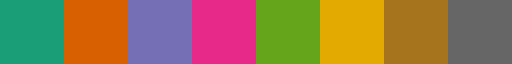

In [11]:
colormap

In [12]:
df = df.dropna(subset=['time'])

In [13]:
df.head()

,pretreated_file_name,hcr,animal_size,time,shh_segm,fgf_segm,dusp_segm,volume_40pc_8um_shh,volume_40pc_8um_fgf,volume_40pc_8um_dusp,...,volume_60pc_8um_fgf,volume_60pc_8um_dusp,volume_70pc_8um_shh,volume_70pc_8um_fgf,volume_70pc_8um_dusp,volume_80pc_8um_shh,volume_80pc_8um_fgf,volume_80pc_8um_dusp,color,marker
0,hcr11_lb27_fl,11,1.5,1,yes,yes,yes,37169,184367,212516,...,69197,72234,6210,33733,39699,3082,12253,16087,"[0.10588235294117647, 0.6196078431372549, 0.46...",o
1,hcr11_lb28_fl,11,1.5,1,yes,yes,yes,29663,327769,118669,...,156360,37507,6225,93522,16287,2572,45073,5176,"[0.10588235294117647, 0.6196078431372549, 0.46...",o
2,hcr11_lb28_fr,11,1.5,1,yes,yes,yes,17366,85413,31615,...,35106,14390,2554,19828,8793,1301,8933,4636,"[0.10588235294117647, 0.6196078431372549, 0.46...",o
3,hcr15_lb41_fl,15,1.5,1,yes,yes,yes,40281,358592,530422,...,87099,267052,10052,36472,137640,5607,16370,58033,"[0.10588235294117647, 0.6196078431372549, 0.46...",o
4,hcr16_lb44_fl,16,1.5,1,yes,yes,yes,43358,333298,285693,...,164983,129834,10990,96011,68479,5183,45063,28987,"[0.10588235294117647, 0.6196078431372549, 0.46...",o


## 50%

shh
mean_shh 145712.20634920636
std_shh 210834.14355350652


fgf
mean_fgf 340128.4761904762
std_fgf 407041.7829892801


dusp
mean_dusp 1636734.8245614036
std_dusp 2426326.8995192326




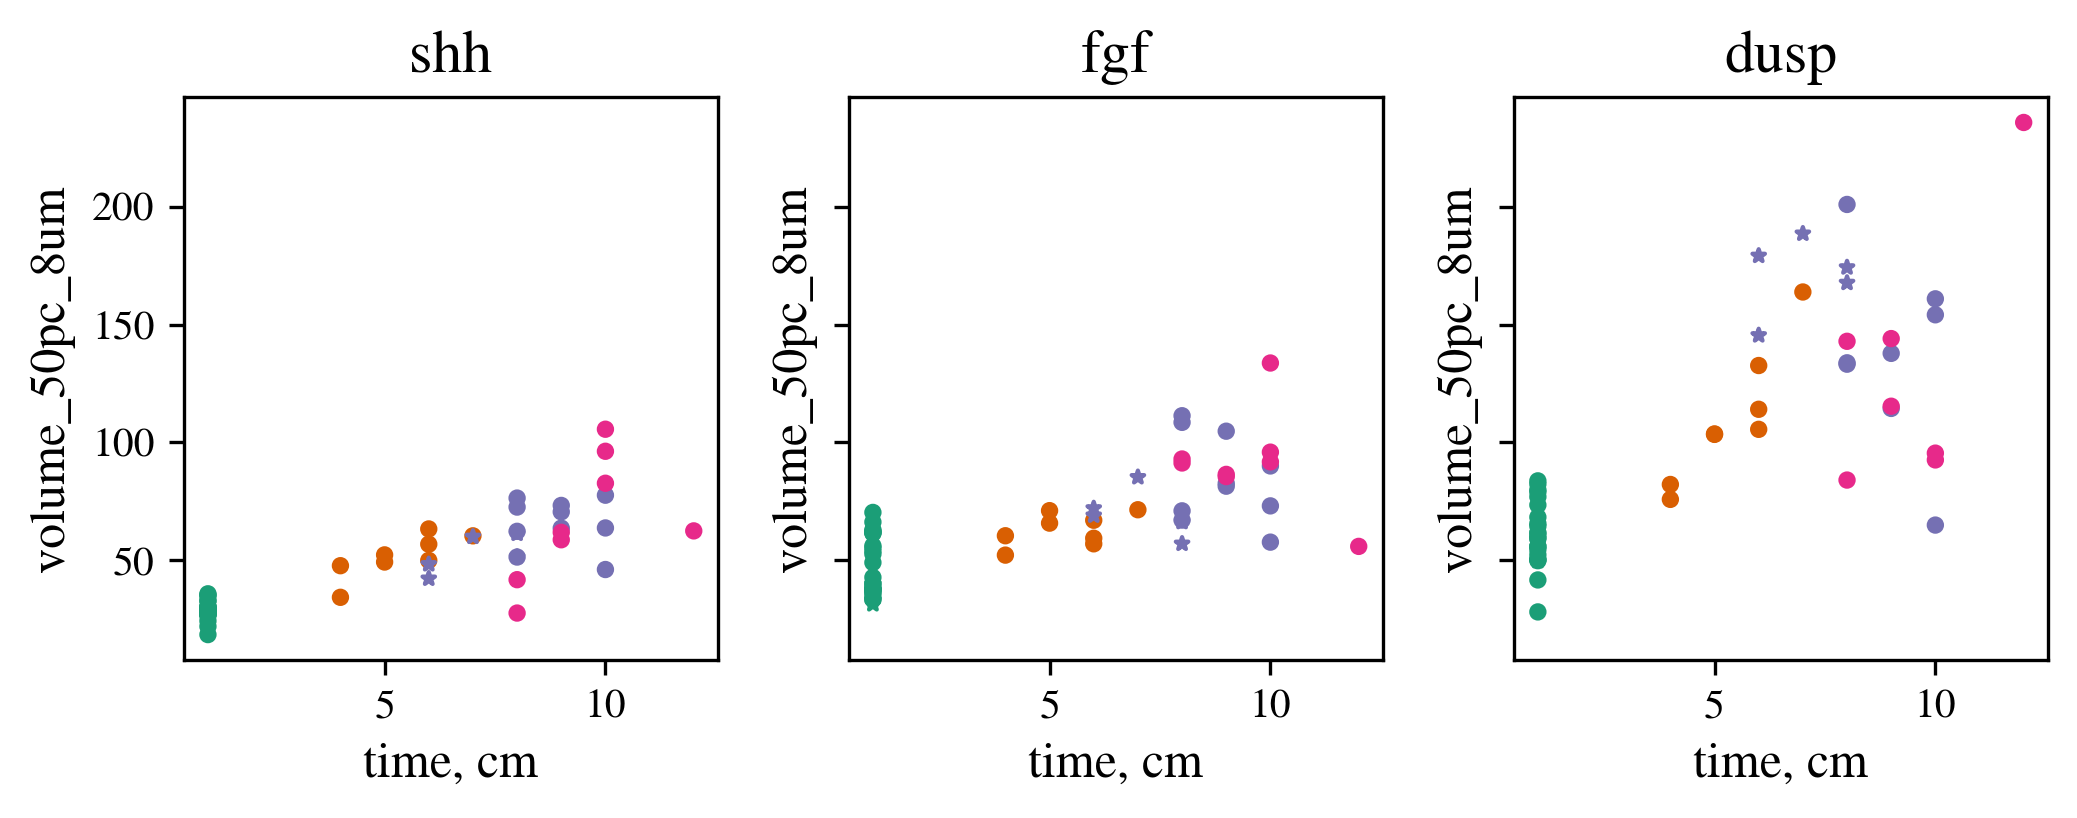

In [14]:
to_plot = 'volume_50pc_8um'

nrows, ncols = 1, 3

fig, ax = plt.subplots(nrows, ncols, figsize=(default_figsize["large"][0], default_figsize["large"][1]/3), sharex=False, sharey=True)

for i, morph in enumerate( ['shh', 'fgf', 'dusp'] ): 
    
    df_to_plot = df.dropna(subset=[f'{to_plot}_{morph}'])

    print(morph)
    mean = df_to_plot[ f'{to_plot}_{morph}' ].mean()
    print( f'mean_{morph}', mean )
    std  =  df_to_plot[ f'{to_plot}_{morph}' ].std()
    print( f'std_{morph}',  std )
    print('\n')
    
    ax = plt.subplot(nrows, ncols, i+1)
    
    for marker_type in df_to_plot['marker'].unique():
        subset = df_to_plot[df_to_plot['marker'] == marker_type]
        ax.scatter(
            subset['time'],
            np.array( subset[f'{to_plot}_{morph}'] )**(1/3),
            color=subset['color'],  # Use the color column
            marker=marker_type,
            s=10  # Marker size
        )

    ax.set_xlabel( 'time, cm' )
    ax.set_ylabel( to_plot )
    ax.set_title( morph )

    """
    # Add labels to each point
    for j, row in df_to_plot.iterrows():
        if row[f'{to_plot}_{morph}'] <= mean:
            ax.text(
                row['time'],  # X-coordinate
                row[f'{to_plot}_{morph}'],  # Y-coordinate
                row['pretreated_file_name'],  # Label text
                fontsize=2,  # Very small font
            )
    """

plt.tight_layout()
plt.savefig(f'volumes/{to_plot}.pdf')
plt.show()